# Stock market predictions - Decision Trees and Random Forests

Welcome to my rather scuffed and, frankly, kinda shit implementation of the Decision Tree and Random Forest algorithms for stock market predictions.

The data used in this notebook is sourced from [this Kaggle dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs). Data from the GE stock ticker is used in specific, which can be found in the file "ge.us.txt" in CSV format. The dataset includes OHLC prices and the volume, all in 1-day intervals.

## Goals

The project's goal is to use the models above to predict the closing prices of a certain stock ticker. Namely, we want to predict the closing prices of the stocks over the next m days.

# Data preprocessing

## Importing modules

In [39]:
from joblib import parallel_backend
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import parallel_backend
from xgboost import XGBRegressor
import seaborn as sns

# Utils

In [40]:
def evaluate(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test R2: {r2:.2f}")
    print(f"Test MAPE: {mape:.2f}")

In [41]:
def plot_prediction(y_pred, X_test):
    results = X_test.copy()
    results['Actual'] = y_test
    results['Predicted'] = y_pred
    results = results[['Actual', 'Predicted']]
    print(results.tail())

    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['Actual'], label='Actual', color='blue')
    plt.plot(results.index, results['Predicted'], label='Predicted', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Stock Closing Price')
    plt.title('Actual vs Predicted Closing Prices')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [42]:
def compare_train_test(model, X_train, X_test, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)


    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"{model_name} Performance:")
    print(f"Training RMSE: {train_rmse:.2f}, R2: {train_r2:.2f}, MAPE: {train_mape:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}, MAPE: {test_mape:.2f}")
    print()


## Pulling data

In [44]:
df = pd.read_csv("https://github.com/noeruchangd/MLProject/blob/master/data/ge.us.txt?raw=true")

df.drop(['OpenInt','Volume'], axis=1, inplace=True)
df=df.tail(7500)

print(df)

             Date     Open     High      Low    Close
6558   1988-02-05   2.8902   2.9224   2.8176   2.8341
6559   1988-02-08   2.8098   2.8500   2.7936   2.8176
6560   1988-02-09   2.8098   2.8422   2.7693   2.8422
6561   1988-02-10   2.8341   2.8822   2.7859   2.8822
6562   1988-02-11   2.8579   2.9549   2.8422   2.8744
...           ...      ...      ...      ...      ...
14053  2017-11-06  20.5200  20.5300  20.0800  20.1300
14054  2017-11-07  20.1700  20.2500  20.1200  20.2100
14055  2017-11-08  20.2100  20.3200  20.0700  20.1200
14056  2017-11-09  20.0400  20.0710  19.8500  19.9900
14057  2017-11-10  19.9800  20.6800  19.9000  20.4900

[7500 rows x 5 columns]


# Preprocessing steps

In [45]:
df.describe()
df.set_index('Date', inplace=True)

print(df.dtypes)
# plt.figure(figsize = (10 , 5))
# sns.lineplot(df , x = df.index , y = 'Close')


Open     float64
High     float64
Low      float64
Close    float64
dtype: object


Preliminary plotting

Text(0.5, 0, 'Date')

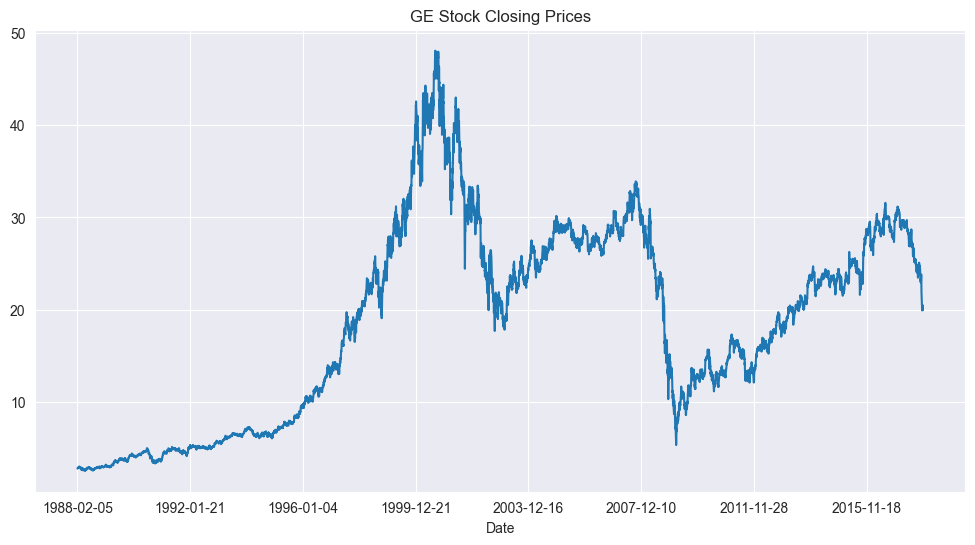

In [46]:
df['Close'].plot(title='GE Stock Closing Prices', figsize=(12, 6))
plt.xlabel('Date')



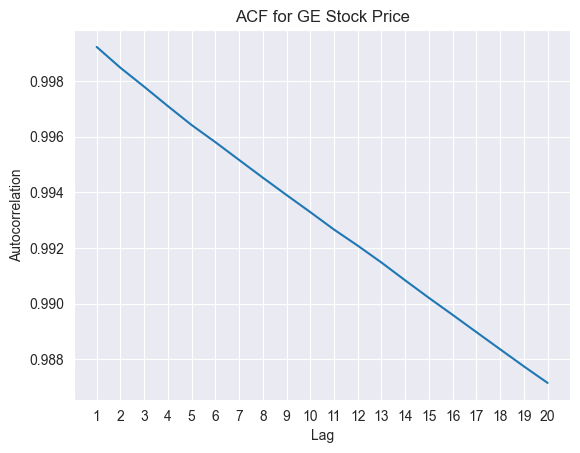

In [47]:
import statsmodels.api as sm # Shoutout to Chau for this!

# ACF for multiple lags
acf = sm.tsa.acf(df['Close'], nlags=20)

# Plot the ACF
plt.plot(range(1, 21), acf[1:])  # Start from lag=1
plt.title('ACF for GE Stock Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

Feature engineering

In [49]:
# Basics
df['Average_price'] = (df['Close'] + df['Open']) / 2


# Moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
# EMAs
df['EMA_5'] = df['Close'].rolling(window=5).mean()
df['EMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_20'] = df['Close'].rolling(window=20).mean()

df['STD_5'] = df['Close'].rolling(window=5).std()
df['STD_10'] = df['Close'].rolling(window=10).std()
df['STD_20'] = df['Close'].rolling(window=20).std()
# Lags
df['Close_t-1'] = df['Close'].shift(1)
df['Close_t-2'] = df['Close'].shift(2)
df['Close_t-3'] = df['Close'].shift(3)
#
df.describe()

,Open,High,Low,Close,Average_price,MA_5,MA_10,MA_20,EMA_5,EMA_10,EMA_20,STD_5,STD_10,STD_20,Close_t-1,Close_t-2,Close_t-3
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7496.000000,7491.000000,7481.000000,7496.000000,7491.000000,7481.000000,7496.000000,7491.000000,7481.000000,7499.000000,7498.000000,7497.000000
mean,18.747767,18.940454,18.544260,18.746651,18.747209,18.750499,18.755341,18.764458,18.750499,18.755341,18.764458,0.255339,0.348161,0.479082,18.746419,18.746253,18.746070
std,10.651652,10.771197,10.530538,10.654252,10.651695,10.648772,10.643475,10.633699,10.648772,10.643475,10.633699,0.266905,0.339687,0.438698,10.654944,10.655644,10.656343
min,2.600500,2.616600,2.560200,2.584200,2.596350,2.619840,2.638400,2.658925,2.619840,2.638400,2.658925,0.000000,0.014906,0.027617,2.584200,2.584200,2.584200
25%,7.668550,7.734900,7.606250,7.668550,7.664637,7.665445,7.662520,7.669780,7.665445,7.662520,7.669780,0.076850,0.112962,0.160111,7.664500,7.660450,7.656400
50%,20.100000,20.312000,19.873500,20.102000,20.098500,20.097300,20.187800,20.230550,20.097300,20.187800,20.230550,0.173827,0.249847,0.354751,20.102000,20.102000,20.102000
75%,27.350000,27.567000,27.132000,27.351000,27.355000,27.360650,27.373150,27.419250,27.360650,27.373150,27.419250,0.329743,0.461802,0.637881,27.352000,27.353000,27.354000
max,47.751000,48.459000,47.596000,48.056000,47.856000,47.521400,47.240200,46.887450,47.521400,47.240200,46.887450,2.703550,3.492558,3.526096,48.056000,48.056000,48.056000


<Axes: >

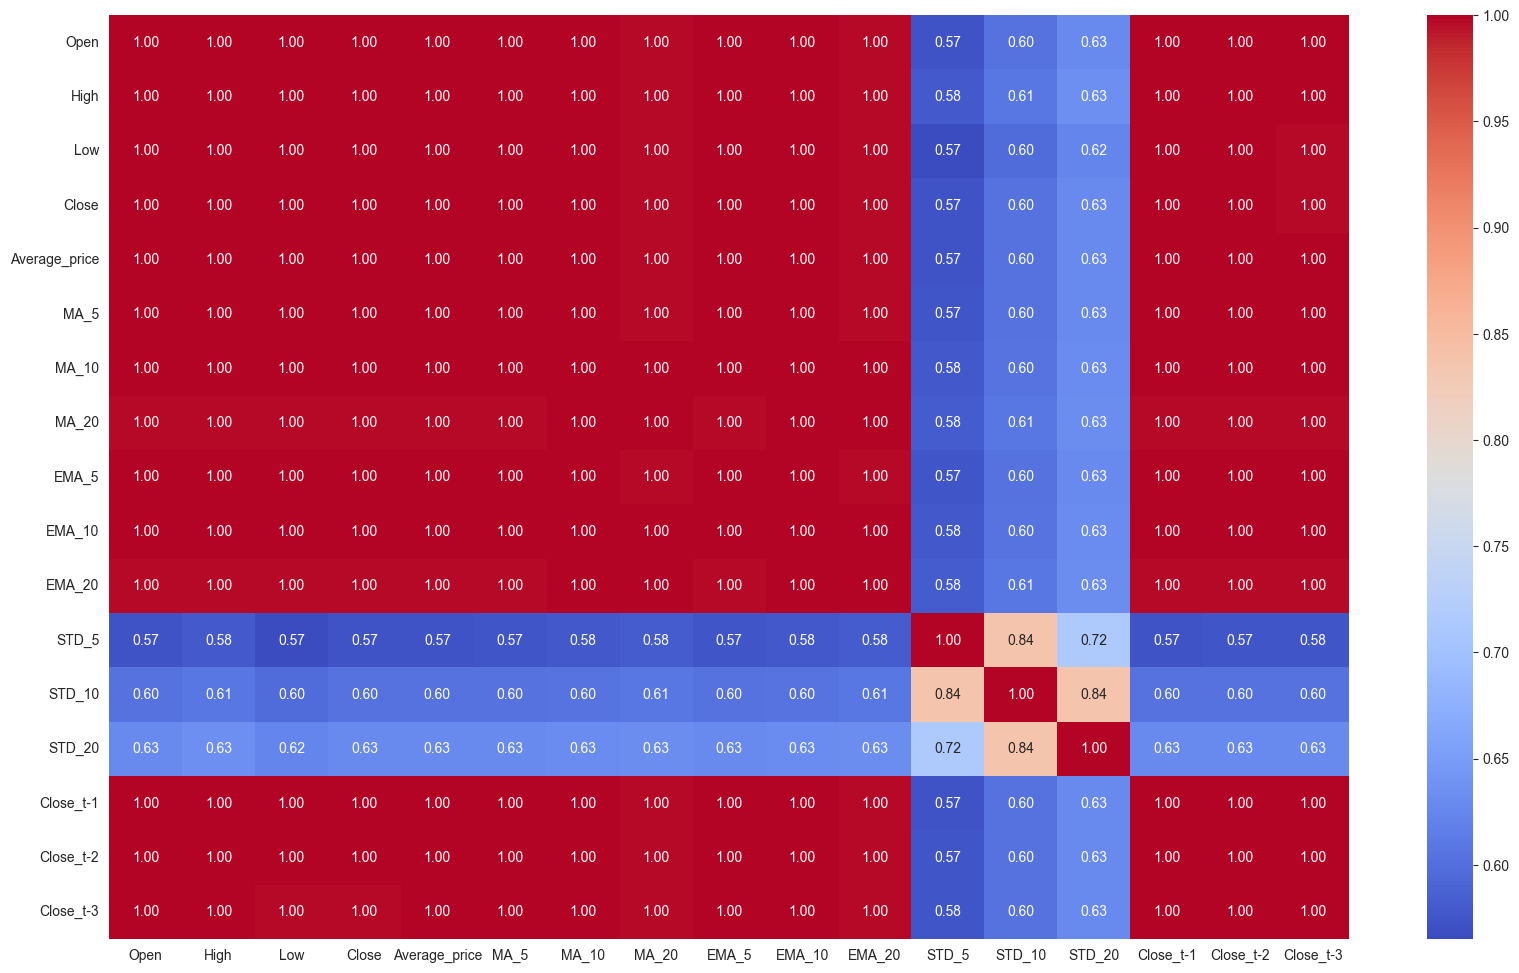

In [50]:
corr = df.corr()

plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

Splitting test and train sets

In [51]:
prediction_days = 10
df['Target'] = df['Close'].shift(-prediction_days)
df.dropna(inplace=True)

X = df.drop(columns=['Target'])
y = df['Target']

print(y.tail())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=False)

Date
2017-10-23    20.13
2017-10-24    20.21
2017-10-25    20.12
2017-10-26    19.99
2017-10-27    20.49
Name: Target, dtype: float64


# Models

Decision tree (with only max_depth adjusted)

C:\Users\Admin\PycharmProjects\MLProject\.venv\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 2/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.340 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5;, score=-3.340 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=3;, score=-1.363 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-1.363 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-5.761 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5;, score=-3

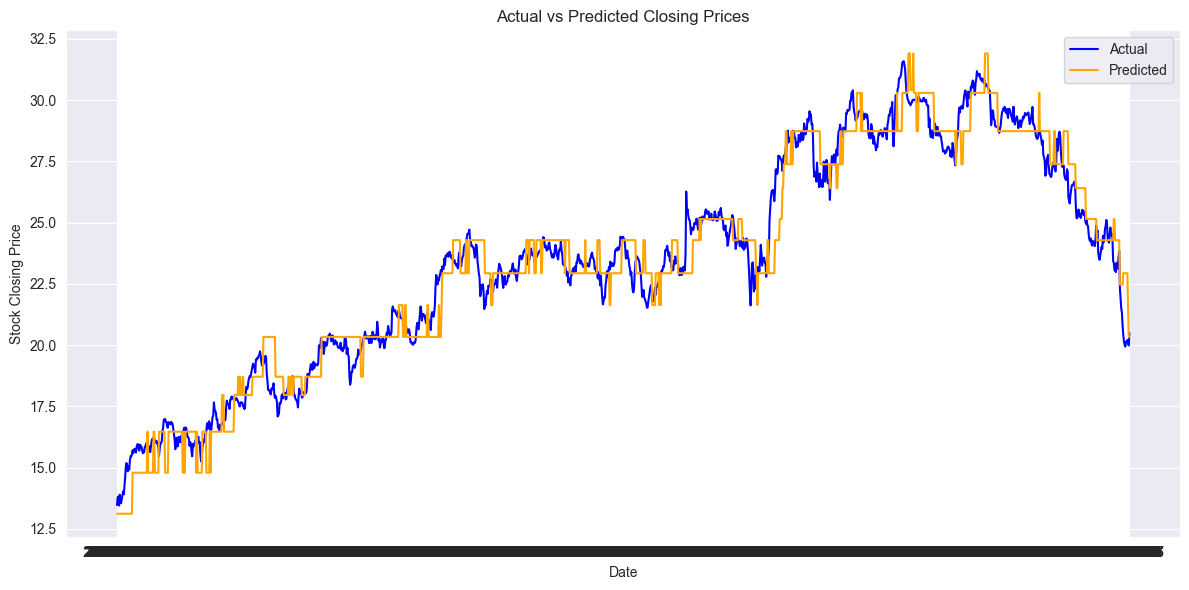

Decision Tree Performance:
Training RMSE: 1.03, R2: 0.99, MAPE: 0.04
Test RMSE: 0.97, R2: 0.95, MAPE: 0.03



In [52]:
param_grid_DT = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features':  [None, 'log2'],
    'criterion': ['friedman_mse','squared_error'],
    'ccp_alpha': [0.01, 0.015]}

tree = GridSearchCV(estimator=DecisionTreeRegressor(),
                           param_grid=param_grid_DT,
                           cv=5,
                           scoring='neg_mean_squared_error', verbose=3,n_jobs=-1)

with parallel_backend('threading'):
    tree.fit(X_train, y_train)

print("Best Hyperparameters:", tree.best_params_)
print("Best Accuracy:", tree.best_score_)

y_pred = tree.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

compare_train_test(tree, X_train, X_test, y_train, y_test, "Decision Tree")

Random Forest

Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\Admin\PycharmProjects\MLProject\.venv\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


[CV 1/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=-16.630 total time=   3.1s
[CV 2/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=-19.229 total time=   3.2s
[CV 3/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=-1.824 total time=   3.3s
[CV 2/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-18.874 total time=   3.3s
[CV 1/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-15.626 total time=   3.4s
[CV 3/3] END bootstrap=Tru

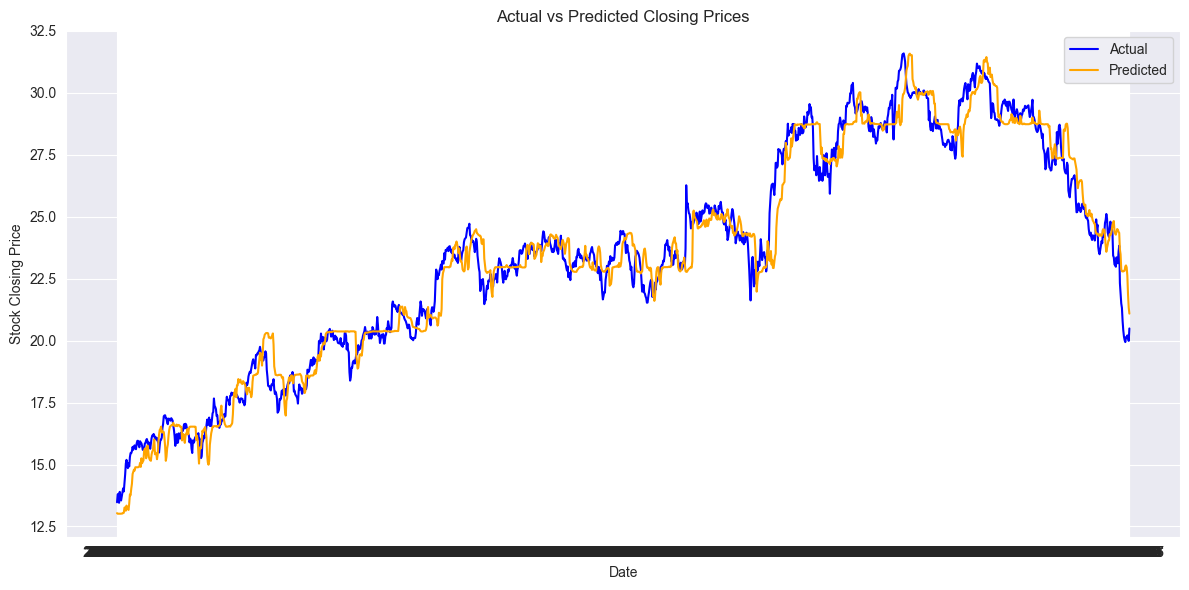

In [53]:
param_grid_RF ={
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features':  ['log2', 'sqrt'],
    'criterion': ['friedman_mse'],
    'ccp_alpha': [0.01],
    'n_estimators': [100, 250, 500],
    'bootstrap': [True]
}

forest = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid_RF,
                           cv=3,
                           scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

with parallel_backend('threading'):
    forest.fit(X_train, y_train)

print("Best Hyperparameters:", forest.best_params_)
print("Best Accuracy:", forest.best_score_)

y_pred = forest.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

Gradient Boosting

In [54]:
param_grid_GBR ={
    'max_depth': [15, 20],
    'n_estimators': [100, 200, 300],
    'min_samples_leaf': [25, 40, 60],
    'learning_rate': [0.2, 0.3, 0.4],
    'ccp_alpha': [0.01, 0.015],
    'criterion': ['friedman_mse']
}
grad = GridSearchCV(estimator=GradientBoostingRegressor(),
                           param_grid=param_grid_GBR,
                           cv=3,
                           scoring='neg_mean_squared_error',verbose=3,n_jobs=-1)

with parallel_backend('threading'):
    grad.fit(X_train, y_train)

print("Best Hyperparameters:", grad.best_params_)
print("Best Accuracy:", grad.best_score_)

y_pred = grad.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

C:\Users\Admin\PycharmProjects\MLProject\.venv\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 2/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=15, min_samples_leaf=40, n_estimators=100;, score=-20.817 total time=  10.1s
[CV 2/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=15, min_samples_leaf=25, n_estimators=100;, score=-21.473 total time=  11.1s
[CV 3/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=15, min_samples_leaf=25, n_estimators=100;, score=-1.812 total time=  11.3s
[CV 1/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=15, min_samples_leaf=25, n_estimators=100;, score=-23.085 total time=  11.5s
[CV 1/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=15, min_samples_leaf=40, n_estimators=100;, score=-21.757 total time=  13.4s
[CV 3/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=15, min_samples_leaf=40, n_estimators=100;, score=-1.690 tota

KeyboardInterrupt: 

XGBoost

In [31]:
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [250, 300, 400],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_cv = GridSearchCV(XGBRegressor(), param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

with parallel_backend('threading'):
    xgb_cv.fit(X_train, y_train)

print("Best Hyperparameters:", xgb_cv.best_params_)
print("Best Accuracy:", xgb_cv.best_score_)

y_pred = xgb_cv.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)
compare_train_test(xgb_cv, X_train, X_test, y_train, y_test, "XGBoost")

C:\Users\Admin\PycharmProjects\MLProject\.venv\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=250, subsample=0.8;, score=-19.632 total time=   1.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=250, subsample=0.8;, score=-21.703 total time=   1.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=250, subsample=0.9;, score=-20.703 total time=   1.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=250, subsample=0.9;, score=-1.778 total time=   1.4s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=250, subsample=0.9;, score=-19.858 total time=   1.4s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=250, su

KeyboardInterrupt: 

Test RMSE: 1.00
Test R2: 0.88
Test MAPE: 0.03
            Actual  Predicted
Date                         
2017-10-23   20.13  21.966815
2017-10-24   20.21  21.711909
2017-10-25   20.12  21.928165
2017-10-26   19.99  21.844079
2017-10-27   20.49  21.486085


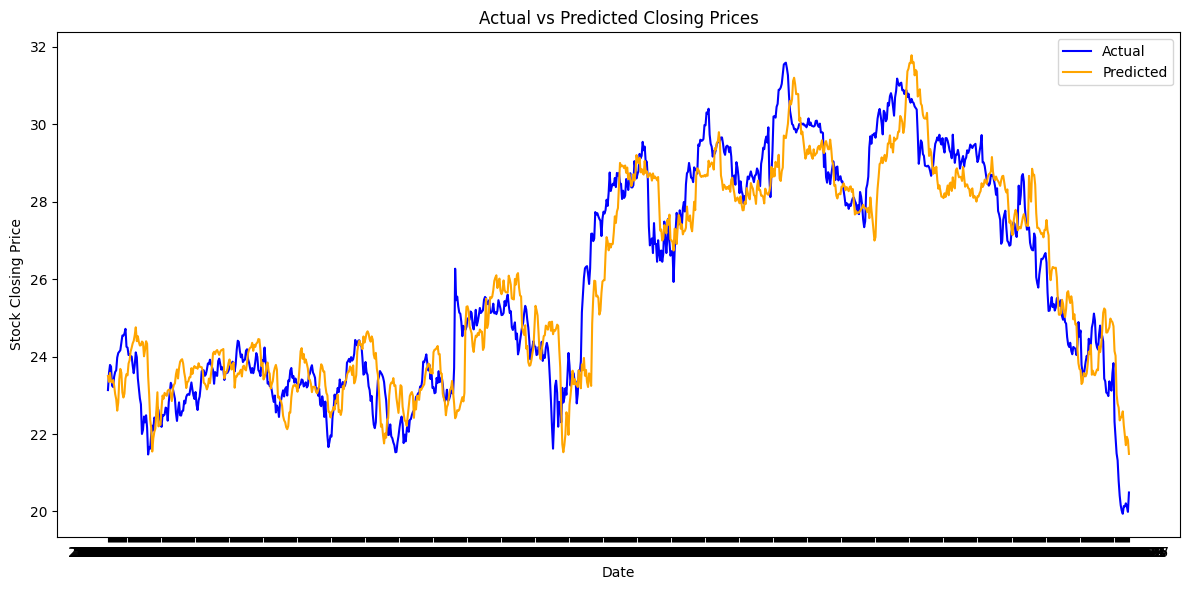

In [110]:
vr = VotingRegressor([('gbr', grad.best_estimator_),
                      ('xgb', xgb),
                      ('rf', forest.best_estimator_)],
                    weights=[2,1,3])
vr.fit(X_train, y_train)
y_pred = vr.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

Overfitting test (comparing performance between testing and training sets)

In [28]:
compare_train_test(tree, X_train, X_test, y_train, y_test, "Decision Tree")
compare_train_test(forest, X_train, X_test, y_train, y_test, "Random Forest")
compare_train_test(grad, X_train, X_test, y_train, y_test, "Gradient Boosting")
compare_train_test(xgb_cv, X_train, X_test, y_train, y_test, "XGBoost")
compare_train_test(vr, X_train, X_test, y_train, y_test, "Democracy")

Random Forest Performance:
Training RMSE: 0.96, R2: 0.99, MAPE: 0.04
Test RMSE: 0.87, R2: 0.96, MAPE: 0.03

